In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.transforms as mtransforms
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc
from scipy.interpolate import interp1d
from astropy.time import Time

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32' or platform == 'linux':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("total_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("total_data/data'+number+'.csv")'
        exec(new_string)
        df_list.append(locals()['df'+number])
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

vims_list = []
for i in range(4,18):
    if i<10:
        exec('vims_200'+str(i)+' = np.load("vims_shift/vims_200'+str(i)+'.npy")')
        vims_list.append(locals()['vims_200'+str(i)])
    else:
        exec('vims_20'+str(i)+' = np.load("vims_shift/vims_20'+str(i)+'.npy")')
        vims_list.append(locals()['vims_20'+str(i)])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma): #amplitude, mean, standard deviation
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def line(x,m,b):
    return m*x+b

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list or type(element) is tuple:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.05])
    return my_fit[1]


scatter_list = []
for number in new_array:
    scatter_list.append(locals()['df'+number])

airmass_data = pd.concat(scatter_list,ignore_index=True)

airmass_data['emission'] *= (np.pi)/180
airmass_data['incidence'] *= (np.pi)/180

all_spectra = []
for i in range(len(airmass_data['spectrum'])):
    all_spectra.append(airmass_data['spectrum'][i])
all_spectra = np.asarray(np.abs(all_spectra))

filter1 = dc(all_spectra)
filter2 = dc(all_spectra)
filter3 = dc(all_spectra)

bad_ind = np.where(filter1[:,69]<=.001)
filter1 = np.delete(filter1,bad_ind,axis=0)

p25 = np.percentile(filter2[:,69],25)
p75 = np.percentile(filter2[:,69],75)
inds = np.where((filter2[:,69] <= p25) | (filter2[:,69] >= p75))
filter2 = np.delete(filter2,inds,axis=0)

# flag data that isn't in the range of mean and 3Sigma - PERL will solve the problem of the amount of data being retrieved
for i in range(256):
    filtered = False
    k = 0
    while filtered == False:
        mean_1 = np.mean(filter3[:,i])
        median = np.median(filter3[:,i])
        std = np.std(filter3[:,i])
        vals = filter3[:,i]
        ind = np.where(np.abs(vals-mean_1)>=3*std)
        filter3[ind,i] = mean_1+(3*std)
        mean_2 = np.mean(filter3[:,i])
        k += 1
        if np.abs(mean_1-mean_2) <= .05*mean_1:
            filtered = True

emission_vals = np.asarray(airmass_data['emission'])
incidence_vals = np.asarray(airmass_data['incidence'])
start_vals = np.asarray(airmass_data['starttime'])

channels = [
(9,20,37,65,107),
(12,24,43,70,115),
(16,27,47,76,118)
]

k_vals = [1.14,1.29,1.60,1.50,1.15]

channels = np.asarray(channels)

correction1 = dc(filter3)
correction2 = dc(filter3)
correction3 = dc(filter3)


aref = np.average(correction1[0,band_channels])
cor = (aref/(np.average(correction1[:,band_channels],axis=1))) # correction factor
correction1 *= cor[:,None]

correction2 /= np.cos(incidence_vals)[:,None]

for i in range(5):
    width = 1
    cor = ((k_vals[i]/2)*(correction3[:,channels[0,i]]+correction3[:,channels[2,i]]))
    correction3[:,channels[0,i]+width:channels[2,i]-width] -= cor[:,None]

shift_dates = [
'2004-01-01T00:00:00.00',
'2005-01-01T00:00:00.00',
'2005-07-01T00:00:00.00',
'2006-01-01T00:00:00.00',
'2006-07-01T00:00:00.00',
'2007-01-01T00:00:00.00',
'2007-07-01T00:00:00.00',
'2008-01-01T00:00:00.00',
'2008-07-01T00:00:00.00',
'2009-01-01T00:00:00.00',
'2009-07-01T00:00:00.00',
'2010-01-01T00:00:00.00',
'2010-07-01T00:00:00.00',
'2011-01-01T00:00:00.00',
'2011-07-01T00:00:00.00',
'2012-01-01T00:00:00.00',
'2012-07-01T00:00:00.00',
'2013-01-01T00:00:00.00',
'2013-07-01T00:00:00.00',
'2014-01-01T00:00:00.00',
'2014-04-19T00:00:00.00',
'2014-07-01T00:00:00.00',
'2015-01-01T00:00:00.00',
'2015-07-01T00:00:00.00',
'2016-01-01T00:00:00.00',
'2016-07-01T00:00:00.00',
'2017-01-01T00:00:00.00',
'2017-07-01T00:00:00.00',
'2017-10-19T00:00:00.00',
]

shift_vals = [0.0,0.0,0.4,1.1,1.9,2.6,3.4,4.1,4.9,5.6,6.0,6.0,6.0,6.0,7.0,7.3,7.7,8.0,8.4,8.7,9.1,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8]
shift_vals = np.asarray(shift_vals)
shift_vals /= 1000

date_vector = Time(shift_dates,format='isot').jd
date_interp = interp1d(date_vector,shift_vals)

all_shifts = date_interp(list(airmass_data['starttime']))

wave_shifts = []
year_list = []
for year in range(2004,2018):
    start_date = Time(str(year)+'-01-01T00:00:00.00',format='isot').jd
    end_date = Time(str(year+1)+'-01-01T00:00:00.00',format='isot').jd
    inds = np.where((start_vals >= start_date) & (start_vals <= end_date))[0]
    if len(inds) > 500:
        shift_ind = np.where(date_vector == Time(str(year)+'-07-01T00:00:00.00',format='isot').jd)[0][0] # Only using one value since all shifts should be the same for a specific date
        wave_shifts.append(shift_vals[shift_ind])
        year_list.append(year)

# Remove outliers


In [2]:
#Define julian date for each spectral observation
total_arr = np.asarray(airmass_data[['starttime','spectrum']])

In [3]:
#Make an array of each central position and the corresponding covariance matrix
m_shifts = []
for spectrum in total_arr[:,1]:
    my_fit,cov = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05],maxfev=20000)
    m_shifts.append([my_fit[1],cov])

m_shifts = np.asarray(m_shifts,dtype=list)

# Individual Shifts

- Remove outliers (anything greater than ~2.05)
- Fit a line to all of these points (should be dslope as a function of time)
- Roger never calculated a b value (around 2.0 micron position, but not in the derived shift)
- Get ALL the data!

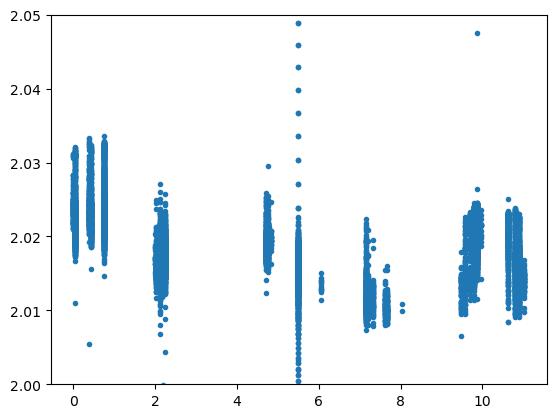

In [4]:
%matplotlib inline
x = (total_arr[:,0]-total_arr[0,0])/365
plt.plot(x,m_shifts[:,0],'.')
plt.ylim([2.0,2.05])
plt.show()

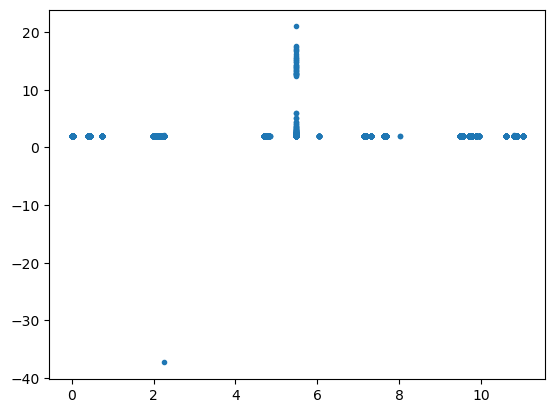

In [5]:
%matplotlib inline

plt.plot(x,m_shifts[:,0],'.')
plt.show()

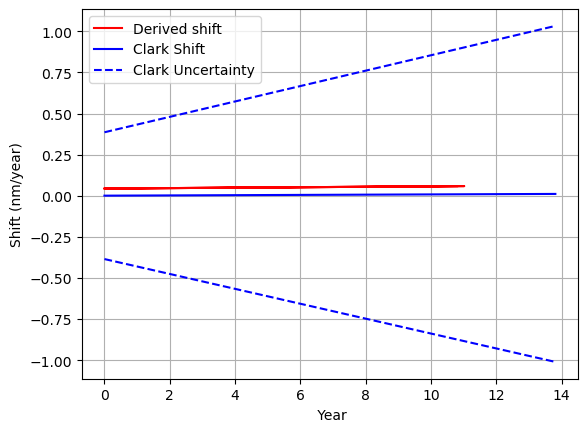

In [4]:
%matplotlib inline
#Subtract first JD from every other in the list and convert to units in years
x = (total_arr[:,0]-total_arr[0,0])/365
#Apply line fit to data, with y_data being the difference between the central position of each spectrum
#?Only central positions?
line_fit,cov = curve_fit(line,x,m_shifts[:,0],p0=(1,0),absolute_sigma=True,sigma=np.ones(len(m_shifts)))
#Plot the shift with +- error
err = np.sqrt(np.diag(cov))
plt.plot(x,line(x,line_fit[0],line_fit[1]-2),'r',label="Derived shift")
# plt.plot(x,line(x,line_fit[0]+err[0],(line_fit[1]+err[1])-2),'r--')
# plt.plot(x,line(x,line_fit[0]-err[0],(line_fit[1]-err[1])-2),'r--')

x2 = (date_vector-date_vector[0])/365
clark_fit,cov2 = curve_fit(line,x2,shift_vals,p0=(1,0),absolute_sigma=True,sigma=np.ones(len(shift_vals)))
err2 = np.sqrt(np.diag(cov2))

# plt.plot(x,line(x,line_fit[0],line_fit[1]-2)-line(0,line_fit[0],line_fit[1]-2),'g')
plt.plot(x2,line(x2,clark_fit[0],clark_fit[1]),'b',label='Clark Shift')
plt.plot(x2,line(x2,clark_fit[0]+err2[0],clark_fit[1]+err2[1]),'b--',label="Clark Uncertainty")
plt.plot(x2,line(x2,clark_fit[0]-err2[0],clark_fit[1]-err2[1]),'b--')
plt.grid()
plt.legend()

plt.xlabel(" Year")
plt.ylabel("Shift (nm/year)")

plt.savefig("C:/Users/lucas/Downloads/shift_fig_3.png",bbox_inches='tight',dpi=300)
plt.show()

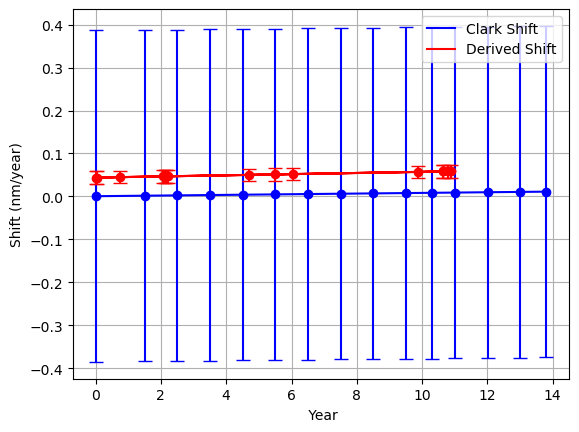

In [41]:
#Plot the same thing as above with error bars

%matplotlib inline

x = (total_arr[:,0]-total_arr[0,0])/365


x2 = (date_vector-date_vector[0])/365
clark_fit,cov2 = curve_fit(line,x2,shift_vals,p0=(1,0),absolute_sigma=True,sigma=np.ones(len(shift_vals)))
err2 = np.sqrt(np.diag(cov2))
plt.plot(x2,line(x2,clark_fit[0],clark_fit[1]),'b',label='Clark Shift')
plt.errorbar(x2[::2],line(x2[::2],clark_fit[0],clark_fit[1]),yerr=err2[1],fmt='o',color='blue',capsize=5)


line_fit,cov = curve_fit(line,x,m_shifts[:,0],p0=(1,0),absolute_sigma=True,sigma=np.ones(len(m_shifts)))
err = np.sqrt(np.diag(cov))
plt.plot(x,line(x,line_fit[0],line_fit[1]-2),'r',label='Derived Shift')
plt.errorbar(x[::903],line(x[::903],line_fit[0],line_fit[1]-2),yerr=err[1],fmt='o',capsize=5,color='red')

plt.grid()
plt.legend(loc='upper right')

plt.xlabel(" Year")
plt.ylabel("Shift (nm/year)")

plt.savefig("C:/Users/lucas/Downloads/shift_fig_new.png",bbox_inches='tight',dpi=300)
plt.show()



In [63]:
line_fit[0]

0.001339530406163747

In [62]:
clark_fit[0]

0.0007666277714089165

In [61]:
np.average(shift_vals)

0.006200000000000001

In [57]:
clark_fit[0] * 1000

0.7666277714089166

In [52]:
clark_fit[0] * 1000

0.7666277714089166

In [47]:
(line_fit[1] -2) * 1000

43.894920863257525

In [44]:
clark_fit[1] * 1000

0.5766386564846815

In [33]:
12655/903

14.014396456256922

In [13]:
err2

array([0.04608776, 0.3857059 ])

In [19]:
clark_fit[0] + err2[0]

0.04685438855060038

In [24]:
(clark_fit[0] + err2[0]) - line_fit[0]  *1000

-1.2926760176131467

In [16]:
line_fit[0] * 1000

1.339530406163747

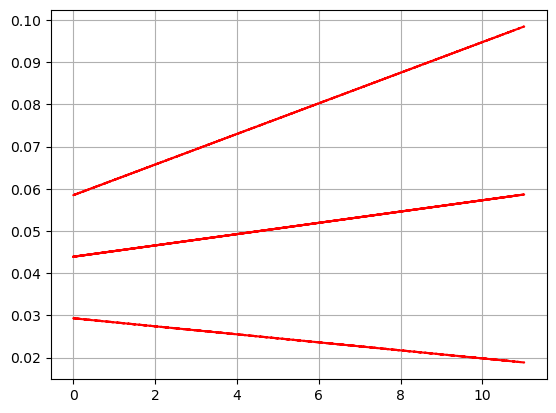

In [7]:
%matplotlib inline

x = (total_arr[:,0] -total_arr[0,0])/365

line_fit,cov = curve_fit(line,x,m_shifts[:,0],p0=(1,0),absolute_sigma=True,sigma=np.ones(len(m_shifts)))
#Plot shift with +- eror
err = np.sqrt(np.diag(cov))
plt.plot(x,line(x,line_fit[0],line_fit[1]-2),'r')
plt.plot(x,line(x,line_fit[0]+err[0],(line_fit[1]+err[1])-2),'r--')
plt.plot(x,line(x,line_fit[0]-err[0],(line_fit[1]-err[1])-2),'r--')

plt.grid()
plt.show()


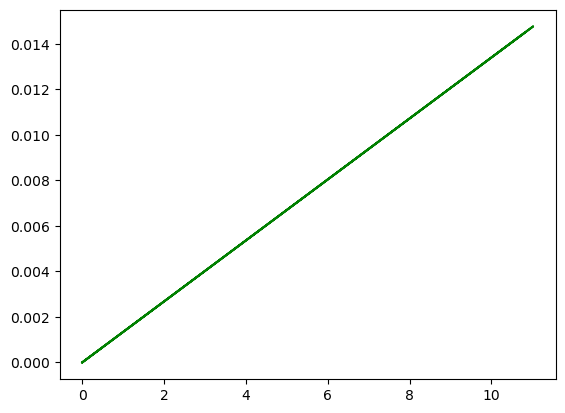

In [8]:
%matplotlib inline

plt.plot(x,line(x,line_fit[0],0),'g')

plt.show()

In [9]:
from manim import *
import os

os.environ["PATH"] = os.environ["PATH"] + r";C:\Users\lucas\AppData\Local\Programs\MiKTeX\miktex\bin\x64\\"

config.media_with = "100%"
config.media_embed = True

render_as_image = "-s --disable_caching -v WARNING LinePlot"

Manim Community v0.17.2

# We're within the error!!

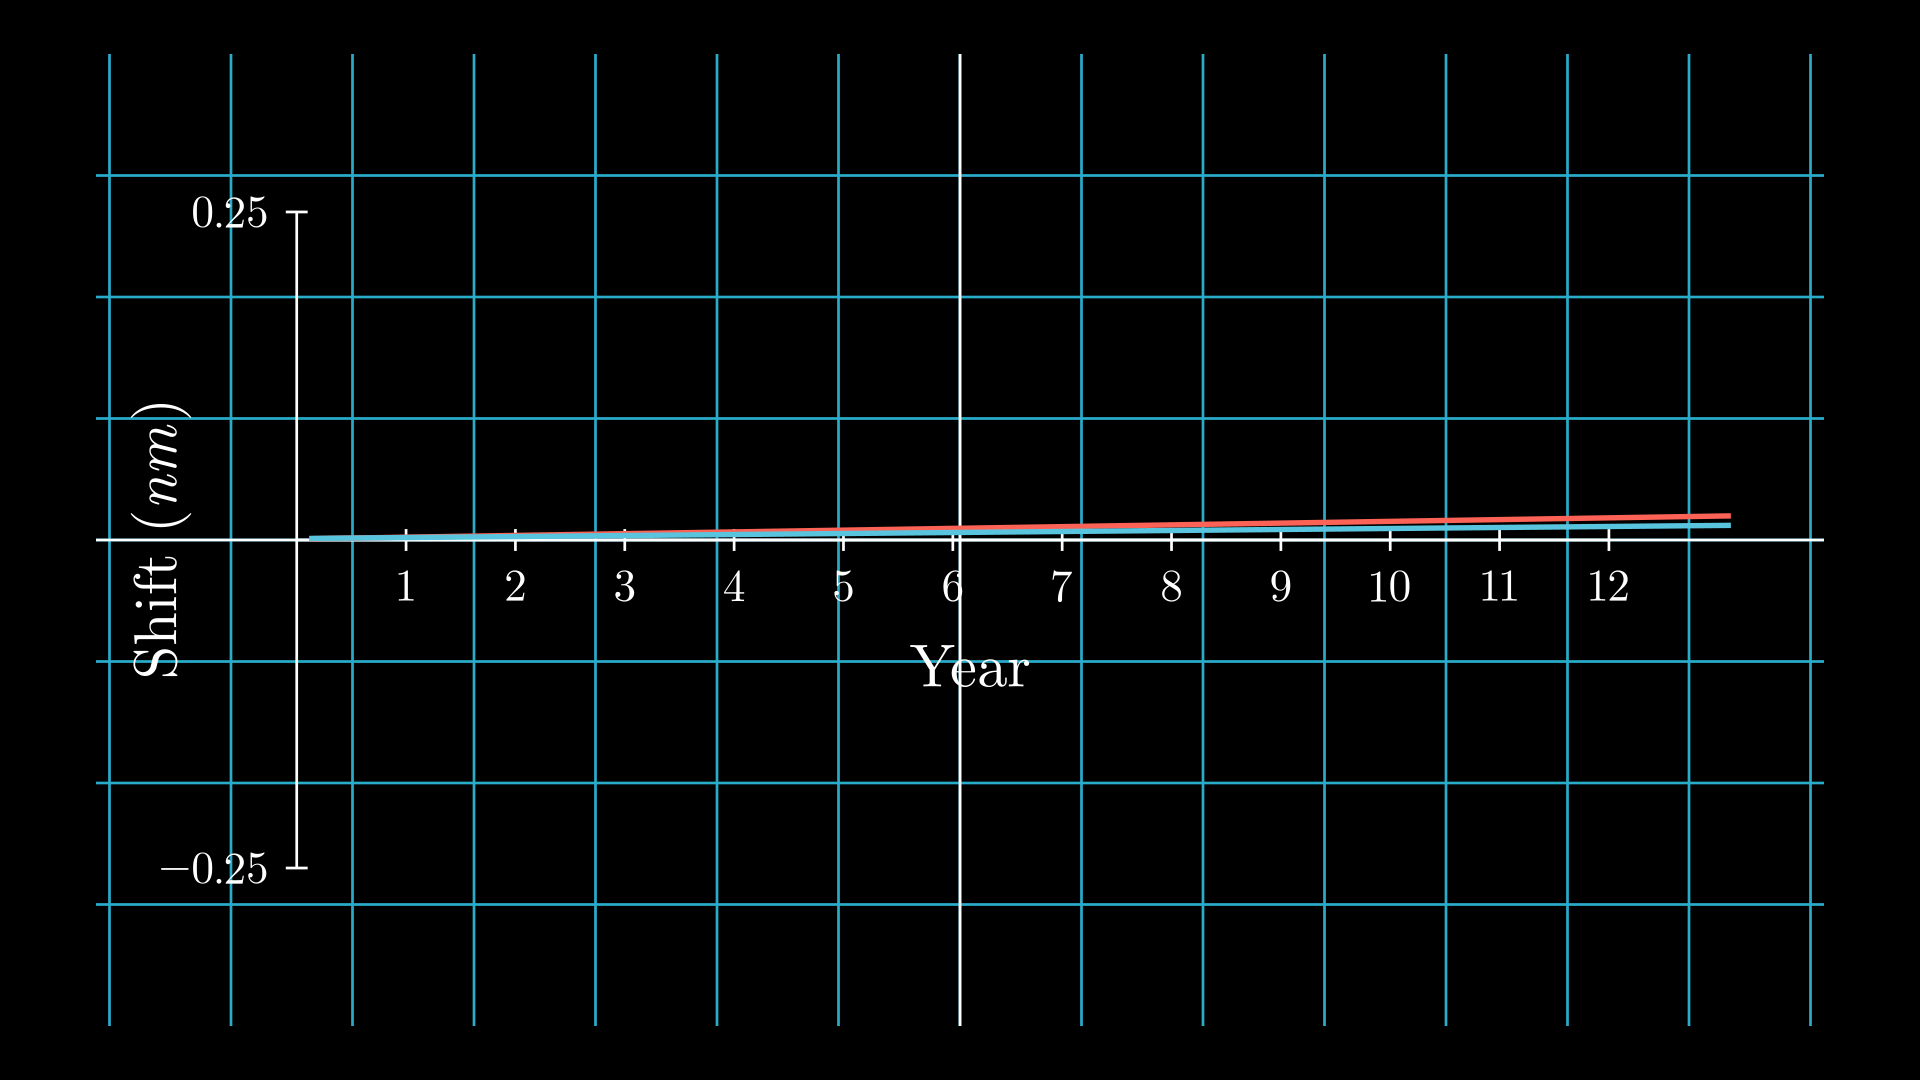

In [10]:
%%manim $render_as_image

config.media_embed = True # <- Use this if you render image

SF = 0.9

#Plot line shift and clark shift
class LinePlot(Scene):
    def construct(self):
        numberplane = NumberPlane()
        ax = Axes(
            x_range=[0,12],
            y_range=[-.25,.25,.25],
            tips=False
        ).scale(SF)

        ax.add_coordinates()
        xlabel = Tex("Year").next_to(ax.x_axis,DOWN)
        ylabel = Tex(r"Shift (\textit{nm})").rotate(PI/2).move_to(ax.y_axis.get_center())

        line_shift = ax.plot(lambda x: line(x,line_fit[0],0), color=RED, x_range=[0, 13])
        clark_shift = ax.plot(lambda x: line(x,clark_fit[0],clark_fit[1]), color=BLUE, x_range=[0, 13])

        self.add(*[mob.scale(SF) for mob in [numberplane,ax, xlabel, ylabel, line_shift, clark_shift]])